In [3]:
import math
import matplotlib.pyplot as plt
from visTools_v2.core_functions.operations.get_patches import get_patches
from visTools_v2.core_functions.corners import Harris_detector
from visTools_v2.core_functions.operations.kmeans import Kmeans
%load_ext autoreload
%autoreload 2
%matplotlib inline


# Helper functions:

In [4]:
from visTools_v2.core_functions.kernels.kernels import kernel
from visTools_v2.core_functions.kernels.gaussian_filter import GaussianFilter
from visTools_v2.core_functions.operations.img_grad import img_grad
from visTools_v2.core_functions.operations.normalize import norm
from visTools_v2.core_functions.operations.reduce_expand import Reduce_stack
from visTools_v2.core_functions.operations.get_patches import *


In [5]:
def load_img(img,bw=True):
    im = plt.imread(img)
    im = np.moveaxis(im,2,0)
    if bw:
        im = np.mean(im,axis=0)
        im = im[np.newaxis,np.newaxis,:,:]
    else:
        im = im[np.newaxis,:,:,:]
    return im

In [6]:
def build_H(I):
    xks = np.indices(np.array(I.R)[:,np.newaxis,:,:].shape).reshape((4,-1))

    patches = get_patches(np.array(I.R)[:,np.newaxis,:,:]
                          .astype(np.float64),
                          xks.T.astype(np.float64),h=3,w=3)
    
    Ixy = patches[0]*patches[1]
    Ixx,Iyy = patches**2

    Ixx = np.sum(Ixx,axis=(2,3,4))
    Iyy = np.sum(Iyy,axis=(2,3,4))
    Ixy = np.sum(Ixy,axis=(2,3,4))

    H = np.stack([[Ixx,Ixy],[Ixy,Iyy]])
    H = np.moveaxis(H,0,3)
    return np.moveaxis(H,0,3)



# Harris Detector (w/Kmeans)

In [7]:
class Harris_detector:
    def __init__(self,im):
        self.im = im
            
    def solve(self,solve=False,blur_window=(3,3),deriv_type=kernel().fd,
                                          sig=1,Red=0,sharp=False,
                                          blur=True,
                         second_moment_window=(3,3),
                        th=0.03,**kmeans_params):

                
        self.second_moment_window=second_moment_window
        self.th = th
        
        self.im = self.im
        self.im = Reduce_stack(self.im,Red)
        
        
        I = img_grad(self.im)
        I.get_grad(th=th,
                      blur=blur,
                      h=blur_window[0],
                      w=blur_window[1],
                      sig=sig,
                      sharp=sharp,g=deriv_type,
                      Red=0)
        
        self.im_shape = I.S.shape
      
        self.I = I
        self.compute()
        try:
            model = Kmeans(**Kmeans_params)
            model.fit(X = self.xk)
            self.xk = model.cs
        except:
            pass
            
        
    
    def compute(self):
        self.H = build_H(self.I)
        self.R = self.get_corner_response(self.H)
        self.apply_threshold(self.R)


    def get_corner_response(self,H):
        
        U,S,V = np.linalg.svd(H.reshape((-1,2,2)))
        alpha=0.04
        self.S=S
        R = S[:,0]*S[:,1] - alpha*(S[:,0]+S[:,1])**2
        R = R.reshape(self.im_shape)
        return R

    def apply_threshold(self,R_):
        th = self.th
     
    
        R_[R_<th]=0
        
        R_ = self.nonMaxSup(R_)
        
        xk = np.argwhere(R_)
           
        plt.figure(figsize=(10,16))
        plt.scatter(xk[:,1],xk[:,0],c='r',s=0.5)
        plt.imshow(self.im[0,0,:,:],**{'cmap':'gray'})
        plt.show()
        self.xk = xk

    def edges(self):
        ed = self.R
        ed[ed<0]=0
        plt.imshow(ed)
        
    def nonMaxSup(self,S):
        n = self.I.n

        S_padded = np.pad(S,((1,1),(1,1)),'mean')
        kp = np.argwhere(S)

        n0 = n[:,kp[:,0],kp[:,1]].T
 
        q0 = kp+np.array([1,1])+n0*1/(2*math.sin(math.pi/8)) 
        q1 = kp+np.array([1,1])-n0*1/(2*math.sin(math.pi/8)) 
        
    
        q0 = np.round(q0).astype(int)
        q1 = np.round(q1).astype(int)
        
        maxs = (S[kp[:,0],kp[:,1]]>S_padded[q0[:,0],q0[:,1]])| (S[kp[:,0],kp[:,1]]>S_padded[q1[:,0],q1[:,1]])
        
        maxs = kp[maxs]
        new_S = np.zeros_like(S)
        new_S[maxs[:,0],maxs[:,1]]=1
        return new_S
        

In [ ]:
# coding: utf-8

# In[1]:


class Transformation:
    def __init__(self):
        ref = {'Rx':self.Rx,'Ry':self.Ry,'Rz':self.Rz,'T':self.T}
        pass
    
    def angle(self,tt):
        return np.pi*tt/180
    
    def Rx(self,tt):
        tt = self.angle(tt)
        return np.array([[1,0,0],[0,np.cos(tt),np.sin(tt)],[0,np.sin(tt),np.cos(tt)]])
    
    def Ry(self,tt):
        tt = self.angle(tt)
        return np.array([[np.cos(tt),0,np.sin(tt)],[0,1,0],[np.sin(tt),0,np.cos(tt)]])
    
    def Rz(self,tt):
        tt = self.angle(tt)
        return np.array([[np.cos(tt),-np.sin(tt),0],[np.sin(tt),np.cos(tt),0],[0,0,1]])
    
    def T(self,t):
        tx,ty = t
        return np.array([[1,0,tx],[0,1,ty],[0,0,1]])
    
    def homog(self,xk):
        ones = np.ones(xk.shape[1])
        return np.vstack((xk,ones))
    
    def rotate_origin(self,xk,tt):
        mu = np.mean(xk,axis=1)[:,np.newaxis]
        return (self.T(mu).dot(self.Rz(tt).dot(self.T(-mu)))).dot(self.homog(xk))[:2,:]


# In[2]:


import numpy as np
import matplotlib.pyplot as plt


# In[3]:


class PCA:
    def __init__(self,**params):
        self.params = params
        self.U = None
        self.V = None
        self.S = None
        self.X_= None
        self.N = None
        self.H = None
        self.W = None
        self.C = None
        self.D_ = None
    
    def fit(self,X,y=None):      
        
  
        self.N = X.shape[1]
        
        self.mu = np.mean(X,axis=1)
        
        D = ((X - self.mu[:,np.newaxis]).dot((X - self.mu[:,np.newaxis]).T))/self.N
        
        self.U,self.S,self.V = np.linalg.svd(D)
        
        self.X_ = X
        self.D_ = D
    
    
    def transform(self,X,nn=None):
        if nn == None:
            if isinstance(self.params,dict):
                self.nn = self.params['n']
            else:
                print('missing number of components nn')
        else:
            self.nn=nn
        
        e = self.V[:self.nn,:].T
        X = e.T.dot(X - self.mu)
        X = (X - X.min())/(X.max()-X.min())
        return X.reshape((self.nn,self.H,self.W,self.C))
    

    def remaining_var(self,n=None):
        if n == None:
            n = self.S.shape[0]
        error = np.cumsum(np.flip(self.S,axis=0))
        return error[:n]/np.sum(self.S)


# In[4]:


def Plot(xk):
    plt.scatter(xk[0,:],xk[1,:],c="r")
    mu = np.mean(xk,axis=1)
    plt.scatter(mu[0],mu[1],c="r",marker="*")
    pass


# In[16]:


def get_rotation(im,xks_rot,plot=True,valign=True):
    pca = PCA()
    pca.fit(xks_rot)
    
    if plot:
        
        Plot(xks_rot)
        plt.imshow(im,**{'cmap':'gray'})

        mu = np.mean(xks_rot,axis=1)[:,np.newaxis]

        X = mu[0]
        Y = mu[1]

        U = pca.V[0][0]*pca.S[0]
        Vv = pca.V[0][1]*pca.S[0]
        plt.quiver(X,Y,U,Vv)

        U = pca.V[1][0]*pca.S[1]
        Vv = pca.V[1][1]*pca.S[1]
        plt.quiver(X,Y,U,Vv)


        ox = np.array([0,1])
        oy = np.array([1,0])
        plt.quiver(X,Y,ox[0],ox[1],color="r")
        plt.quiver(X,Y,oy[0],oy[1],color="r")

    vv = pca.V[0,:] 
    xx = np.array([0,1])
    
    if vv[1]>0:
        tt = np.arccos((xx.dot(vv))/(np.linalg.norm(vv)*np.linalg.norm(xx)))*180/np.pi
    else:
        tt = 360 - np.arccos((xx.dot(vv))/(np.linalg.norm(vv)*np.linalg.norm(xx)))*180/np.pi
    
    if valign:
        T = Transformation()
        xks_rot = T.rotate_origin(xks_rot,-tt)
        if plot:
            plt.figure(figsize=(10,16))
            plt.title("Vertically adjusted")
            Plot(xks_rot)
            plt.imshow(im,**{'cmap':'gray'})
        return tt,xks_rot
    else:
        return tt
        

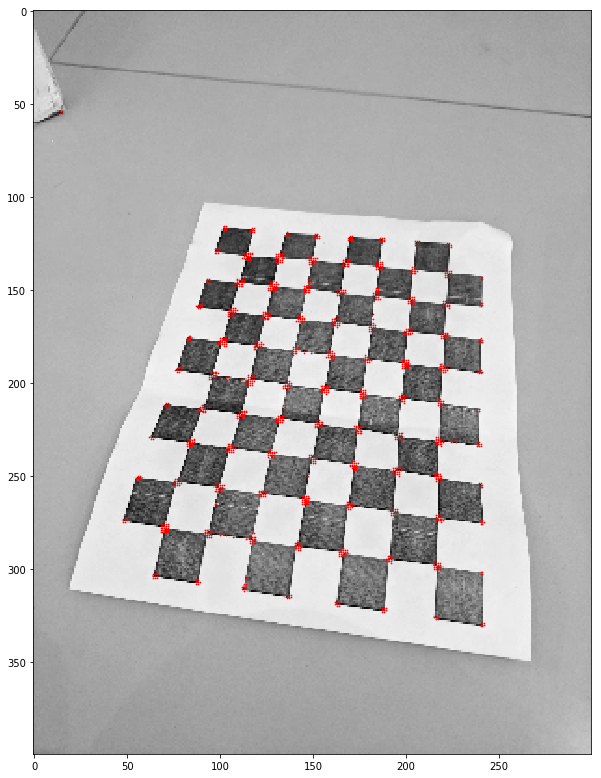

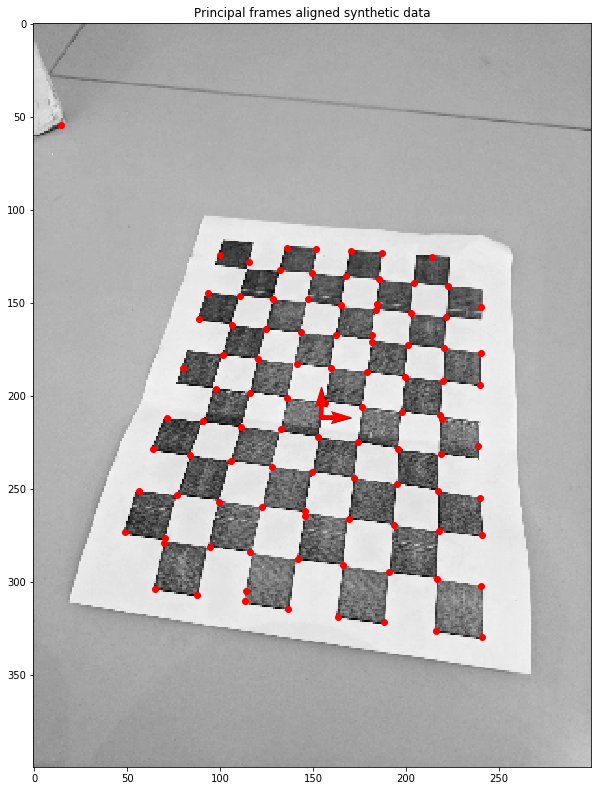

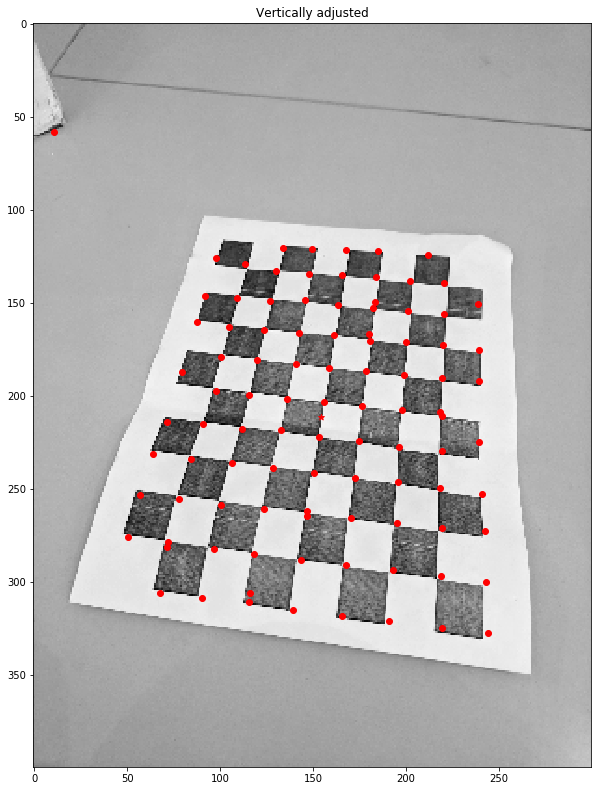

Angle: 1.4191295826476393


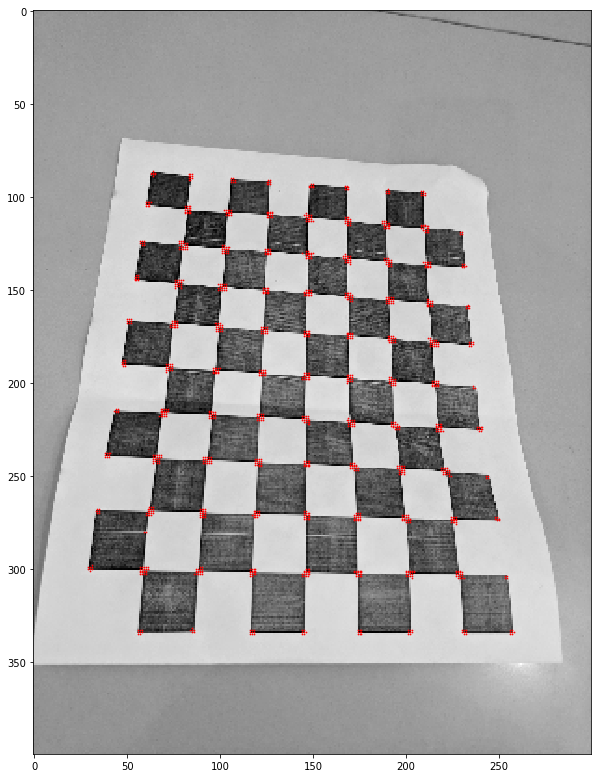

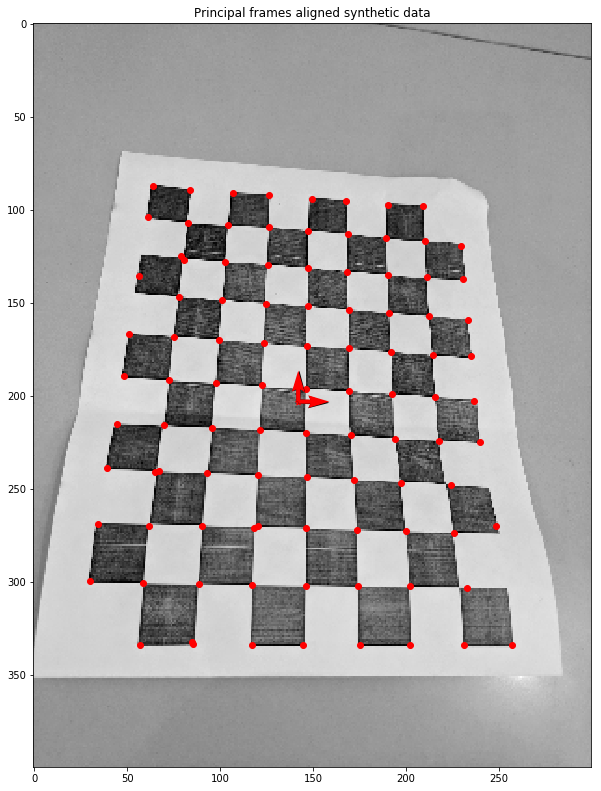

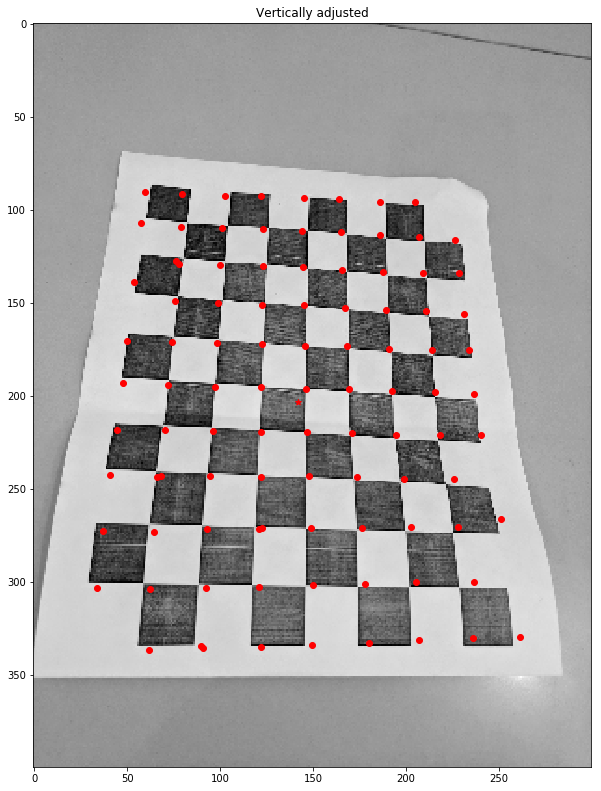

Angle: 2.1196430416034078


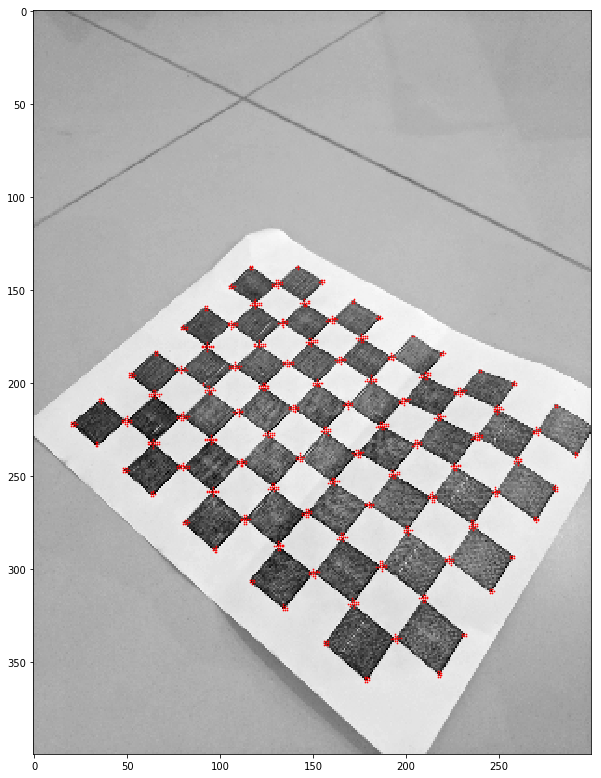

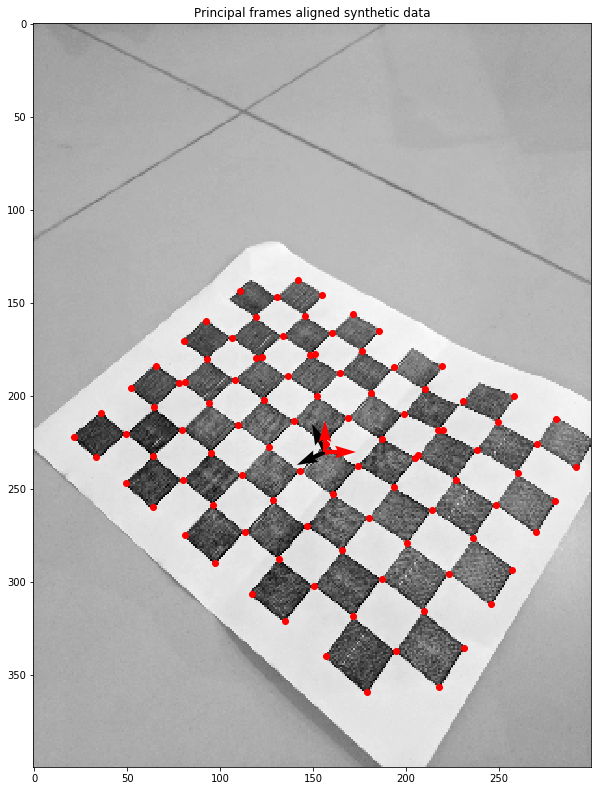

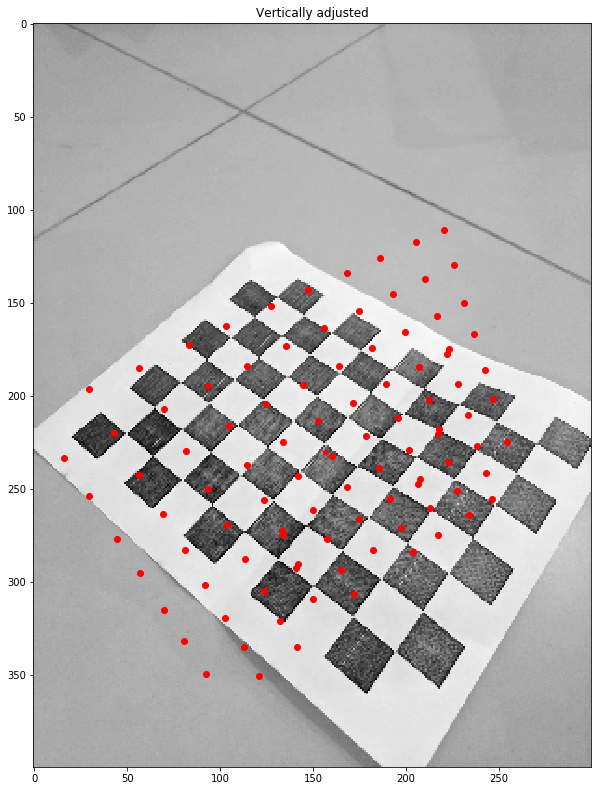

Angle: 245.3020628947463


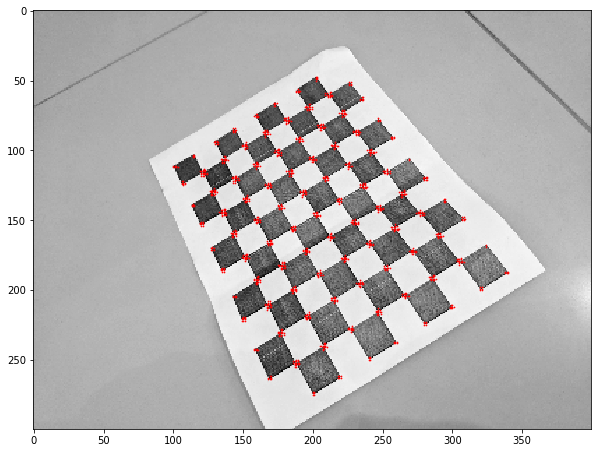

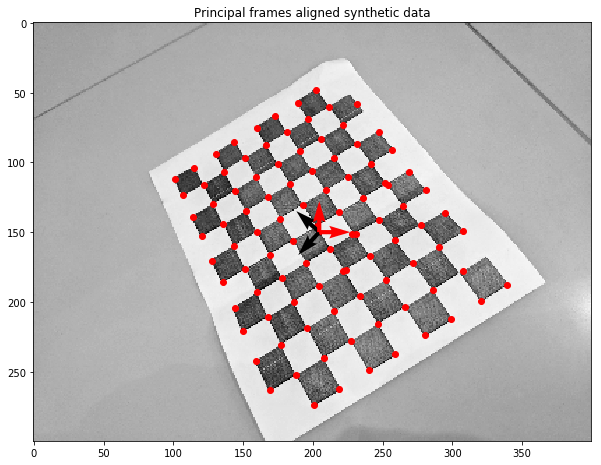

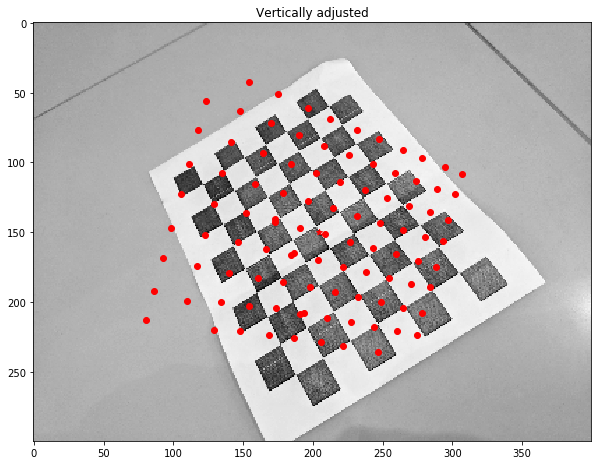

Angle: 222.583064748265


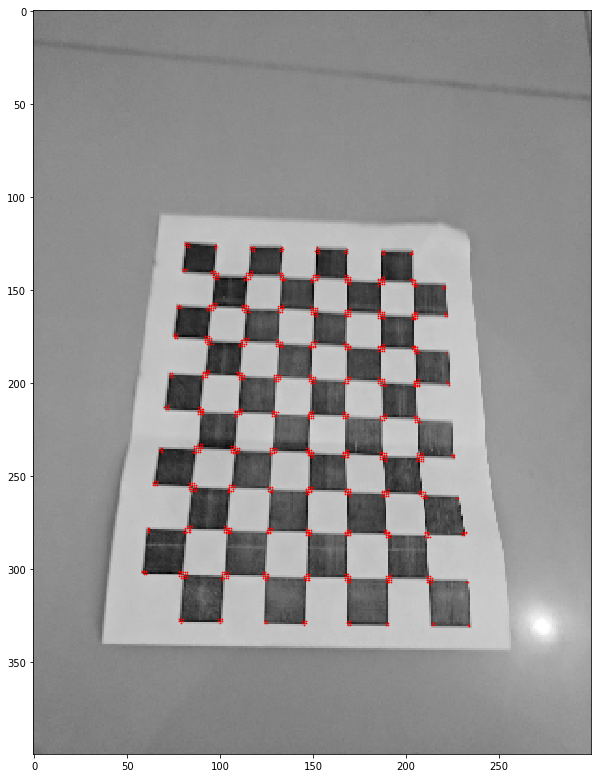

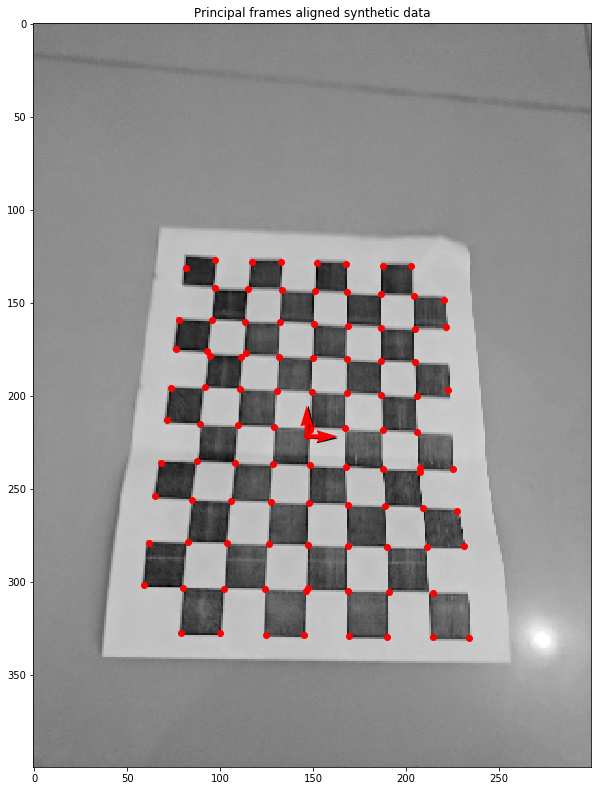

In [ ]:
import os
Kmeans_params ={"k":98,
                "init_method":"k++",
                 "include_coords":False}

imgs = os.listdir("img/calibration/")
img = []
n=0
for i in imgs:
    #plt.title(os.path.join(
    #"img/calibration/",i))
    
    im =  load_img(os.path.join(
    "img/calibration/",i))
    
    img1 = Harris_detector(im)
    
    img1.solve(th=.03,Red=2,**Kmeans_params)

    
    plt.figure(figsize=(10,16))
    plt.title('Principal frames aligned synthetic data')
    tt,_ = get_rotation(img1.im[0,0],np.array([img1.xk[:,1],img1.xk[:,0]]))
    plt.show()
    print('Angle: {}'.format(tt))

    n+=1

In [85]:
y,x = np.mean(img1.xk,axis=0)


array([222.40640182, 146.21591461])

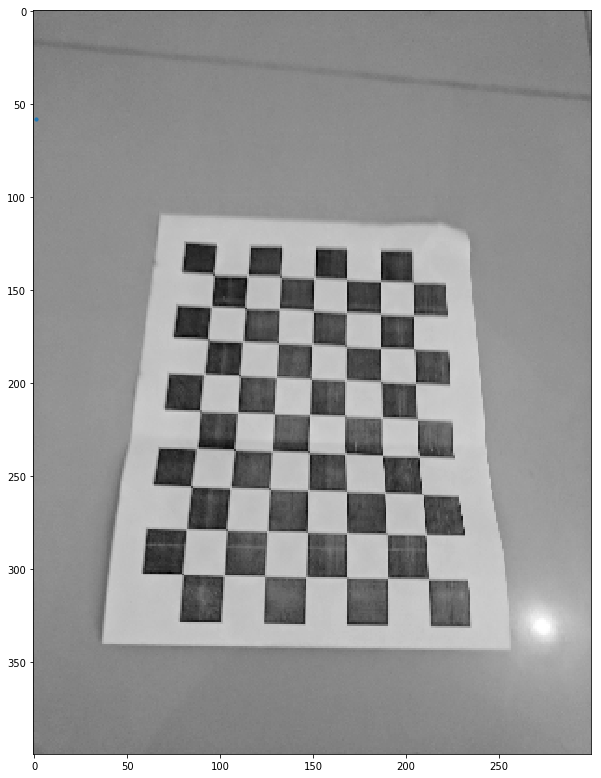

In [84]:
plt.figure(figsize=(10,16))
plt.scatter(1,58,s=10)
plt.imshow(img1.im[0,0],**{'cmap':'gray'})

In [80]:
img1.xk[58,1]

82.125

In [83]:
def img_histogram(bw_im,plot=True):
    bw_im = bw_im*100
    
    MaxVal = bw_im.max()
    MaxRow,MaxCol = bw_im.shape

    H = np.zeros(100)
    
    for i in range(MaxRow):
        for j in range(MaxCol):
            H[int(bw_im[i,j]-1)]+=1
    
    if plot==True:
        plt.title('Image Hstogram (black/white)')
        plt.plot(np.arange(100)/100,H)
        
    return H

In [121]:
def rgb_to_hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v

def RGBB2HSV(im1):

    im1 = np.squeeze(im1)
    
    C,H,W = im1.shape
    im1 = im1.reshape((C,H*W))
    im = np.zeros_like(im1)
    
    
    for i in range(im1.shape[1]):
        r,g,b= im1[:,i]
        im[:,i] = rgb_to_hsv(r, g, b)
        
    im = im.reshape((C,H,W))
    
    return im[np.newaxis,:,:,:]

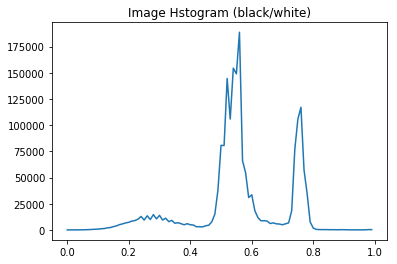

In [112]:
imm = load_img(os.path.join("img/calibration/",i))
norm = lambda x: (x-x.min())/(x.max()-x.min())
_ = img_histogram(norm(imm)[0,0])

In [123]:
#RGBB2HSV(load_img(os.path.join("img/calibration/",i),bw=False))
imm = load_img(os.path.join("img/calibration/",i),bw=False)
imm = RGBB2HSV(imm[0])

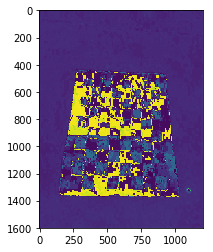

In [136]:
plt.imshow(imm[0][0,:,:])

In [87]:
def threshold(im,a_min,a_max):
    im[im<a_min]=0
    im[im>a_max]=0
    im[(im>a_min)&(im<a_max)]=1
    return im

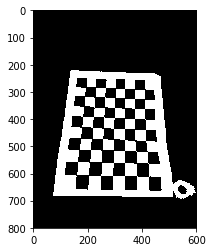

In [104]:
im = threshold(norm(img1.im)[0,0],a_min=0.7,a_max=.85)
plt.imshow(im,**{'cmap':'gray'})

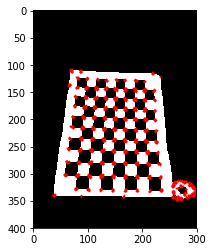

In [105]:
Kmeans_params ={"k":100,
                "init_method":"k++",
                 "include_coords":False}
img2 = Harris_detector(im[np.newaxis,np.newaxis,:,:])
img2.solve(Red=1,th=.001,**Kmeans_params)

In [69]:
im[np.newaxis,np.newaxis,:,:].shape

(1, 1, 800, 600)

'img/calibration/IMG_20180914_194903.jpg'